In [140]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [141]:
wiki_data = pd.read_csv('../input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv', delimiter=',', skipinitialspace=True)
imdb_data = pd.read_csv('../input/imdbmovies/imdb.csv', error_bad_lines=False, warn_bad_lines=False, skipinitialspace=True)

In [142]:
# Take only the interesting columns
#imdb_data = imdb_data[['title', 'imdbRating', 'nrOfWins', 'nrOfNominations', 'nrOfPhotos', 'nrOfNewsArticles', 'nrOfUserReviews']]
imdb_data = imdb_data.drop(['fn', 'tid', 'wordsInTitle', 'url', 'year'], axis=1)

In [143]:
wiki_data.loc[:,'imdb_title'] = wiki_data['Title'].str.strip() + " (" + wiki_data['Release Year'].astype('str') + ")"
all_data = wiki_data.merge(imdb_data, left_on=['imdb_title'], right_on=['title']).drop(['title', 'imdb_title'], axis=1)
all_data.head()

Release Year                        Title Origin/Ethnicity  \
0          1910            A Christmas Carol         American   
1          1912  The Musketeers of Pig Alley         American   
2          1914                The Squaw Man         American   
3          1914   Tillie's Punctured Romance         American   
4          1917                    Cleopatra         American   

                        Director  \
0               J. Searle Dawley   
1                 D. W. Griffith   
2  Oscar Apfel, Cecil B. DeMille   
3                   Mack Sennett   
4              J. Gordon Edwards   

                                                Cast       Genre  \
0               Marc McDermott, Charles Stanton Ogle     unknown   
1                          Elmer Booth, Lillian Gish       drama   
2                                      Dustin Farnum     western   
3  Charlie Chaplin, Marie Dressler, Mabel Normand...      comedy   
4       Theda Bara, Fritz Leiber, Sr., Thurston Hall  historical   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/A_Christmas_Caro...   
1  https://en.wikipedia.org/wiki/The_Musketeers_o...   
2  https://en.wikipedia.org/wiki/The_Squaw_Man_(1...   
3  https://en.wikipedia.org/wiki/Tillie%27s_Punct...   
4  https://en.wikipedia.org/wiki/Cleopatra_(1917_...   

                                                Plot  imdbRating  ratingCount  \
0  The day before Christmas, Ebenezer Scrooge ref...         6.1        316.0   
1  The film is about a poor married couple living...         6.7       1074.0   
2  James Wynnegate (Dustin Farnum) and his cousin...         6.3        570.0   
3  Charles Chaplin portrays a womanizing city man...         7.4       2275.0   
4  Because the film has been lost, the following ...         5.9        233.0   

   ...  News RealityTV  Romance  SciFi  Short  Sport  TalkShow  Thriller  War  \
0  ...     0         0        0      0      1      0         0         0    0   
1  ...     0         0        0      0      1      0         0         0    0   
2  ...     0         0        1      0      0      0         0         0    0   
3  ...     0         0        0      0      0      0         0         0    0   
4  ...     0         0        0      0      0      0         0         0    0   

   Western  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 46 columns]

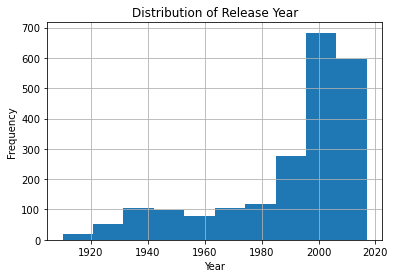

In [144]:
all_data['Release Year'].hist()
plt.title("Distribution of Release Year")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

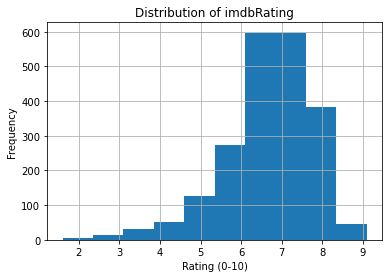

In [145]:
all_data['imdbRating'].hist()
plt.title("Distribution of imdbRating")
plt.xlabel("Rating (0-10)")
plt.ylabel("Frequency")
plt.show()

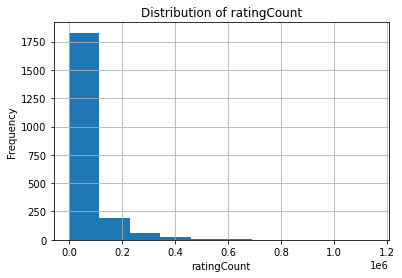

In [146]:
all_data['ratingCount'].hist()
plt.title("Distribution of ratingCount")
plt.xlabel("ratingCount")
plt.ylabel("Frequency")
plt.show()

In [147]:
most_ratings_quarter = all_data.ratingCount.quantile(0.50)
all_data = all_data.loc[(all_data['Release Year'] > 2000) & (all_data['ratingCount'] > most_ratings_quarter)]

In [150]:
# Drop rows with NaN values (we have plenty of data anyways)
all_data = all_data.dropna(axis=0)
# 0 = "haven't seen", 1 = "liked", -1 = "not liked", NaN="not answered"
all_data.loc[:, "Class"] = np.NaN
all_data = all_data.drop_duplicates('Title')
all_data = all_data.reset_index(drop=True)

# Scrape Wikipedia image URLs

In [ ]:
import time
import requests
def get_img_url(wiki_url):
    page = str(requests.get(wiki_url).text)
    start = page.find("//upload")
    
    end_html = page[start:].find("/>") - 1
    end_png = page[start:].find(".png") + 4
    end_jpg = page[start:].find(".jpg") + 4
    end =  min([n for n in [end_html, end_png, end_jpg]  if n > 0])
    
    if start > 0 and end > 0 and len(page[start:start+end]) > 5:
        return page[start:start+end]
    return None

img_urls = []
for index, movie in all_data.iterrows():
    img_urls.append(get_img_url(movie['Wiki Page']))
    print("index:", index, "Done with", 100 * round(index / all_data.shape[0], 3), "%")
    time.sleep(2)
    clear_output()

all_data.loc[:, "Wiki_img"] = np.array(img_urls)

## Load exsisting data

In [153]:
#all_data.to_csv('all_data_no_class.csv')
all_data = pd.read_csv('../input/moviedataset/all_data_no_class(1).csv', index_col=0)
all_data = all_data.drop_duplicates('Title')
all_data = all_data.reset_index(drop=True)

# Data Collection

In [155]:
from IPython.display import clear_output
from IPython.display import IFrame
## Data collection

user_input = None
while user_input != "e":
    try:
        random_movie = all_data.loc[all_data['Class'].isna()].sample()
    except ValueError:
        print("All movies sampled, maybe?")
        break
    
    movie_title = random_movie.Title.values[0]
    wiki_url = random_movie['Wiki_img']
    print(wiki_url.values[0])
    if wiki_url.isna().values[0]:
        print("No image available")
    else:
        display(IFrame(src=wiki_url.values[0],  width=900, height=400))

    print("Instructions: y='yes', n='no', enter='havent seen', e=exit")
    print("Did you like", movie_title, "(" + str(random_movie['Release Year'].values[0]) + ")?")
    user_input = str(input())
    while user_input != "y" and user_input != "n" and user_input != "e" and user_input != "":
        print("Invalid input! Try again.")
        user_input = str(input())
    
    if user_input == "y":
        all_data.loc[all_data['Title'] == movie_title, 'Class'] = 1
    elif user_input == "n":
        all_data.loc[all_data['Title'] == movie_title, 'Class'] = -1
    elif user_input == "":
        all_data.loc[all_data['Title'] == movie_title, 'Class'] = 0
    clear_output()

print("Exited. Now", all_data['Class'].notna().sum(),"/", all_data.shape[0], "movies are labeled.")

Exited. Now 36 / 640 movies are labeled.


# NLP-classifier

In [156]:
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

ml_data = all_data.loc[(all_data['Class'].notna()) & all_data['Class'] != 0]
X = ml_data.Plot.values
y = ml_data.Class.values

text_clf = Pipeline([
     ('vect', CountVectorizer(tokenizer=nltk.word_tokenize, max_features=3000)),
     ('tfidf', TfidfTransformer()),
     ('sampler', RandomUnderSampler()),
     ('clf', MultinomialNB()),
])
#LinearSVC()
print("K-Fold testing:")
accuracies = []
for train_index, test_index in KFold(n_splits=5, shuffle=True).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    text_clf.fit(X_train, y_train)
    accuracies.append(text_clf.score(X_test, y_test))
    print(f'Model test accuracy: {accuracies[-1]:.2f}')
    #print(confusion_matrix(y_test, text_clf.predict(X_test)))

print("Mean accuracy:", round(sum(accuracies)/len(accuracies), 2))

print("\nNormal testing:")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True)
print("Train data size:", X_train.shape[0])
print("Test data size:", X_test.shape[0])
text_clf.fit(X_train, y_train)
print('Model test accuracy:', text_clf.score(X_test, y_test))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, text_clf.predict(X_test)))

K-Fold testing:
Model test accuracy: 1.00
Model test accuracy: 0.00
Model test accuracy: 1.00
Model test accuracy: 1.00
Model test accuracy: 0.00
Mean accuracy: 0.6

Normal testing:
Train data size: 8
Test data size: 2
Model test accuracy: 0.5
[[1 0]
 [1 0]]


# Make recommendation of unseen movies

In [157]:
def get_plot_recommendations(data, clf_pipeline):
    ml_data = data.loc[(data['Class'].notna()) & data['Class'] != 0]
    X_train = ml_data.Plot.values
    y_train = ml_data.Class.values
    clf_pipeline.fit(X_train, y_train)

    X_test = data.loc[(data['Class'].notna()) & data['Class'] == 0].Plot.values

    probs = clf_pipeline.predict_proba(X_test)
    y_pred = probs.argmax(axis=1)
    y_probs = probs.max(axis=1)
    
    top5_idxs = (-y_probs).argsort()[:5]
    bot5_idxs = (y_probs).argsort()[:5]
    top5_recommend = data.loc[(data['Class'].notna()) & data['Class'] == 0].iloc[top5_idxs]
    bot5_recommend = data.loc[(data['Class'].notna()) & data['Class'] == 0].iloc[bot5_idxs]
    return top5_recommend, bot5_recommend

def show_recommendations(top5_recommend, bot5_recommend):
    html_code = "<h3>Recommended:</h3><table><tr>"
    for idx, movie in top5_recommend.iterrows():
        html_code += '<td><img title=' + str(movie.Title) + ' style="max-width:150px;height:auto;" src=' + str(movie.Wiki_img) + '></td>'
    html_code += "</tr></table>"
    display(HTML(html_code))
    
    html_code = "<h3>Disadvised:</h3><table><tr>"
    for idx, movie in bot5_recommend.iterrows():
        if str(movie.Wiki_img) == "nan":
            print(movie.Wiki_img)
        #print(movie.Wiki_img)
        html_code += '<td><img title=' + str(movie.Title) + ' style="max-width:150px;height:auto;" src=' + str(movie.Wiki_img) + '></td>'
    html_code += "</tr></table>"
    display(HTML(html_code))

In [158]:
top5, bot5 = get_plot_recommendations(all_data, text_clf)

In [159]:
show_recommendations(top5, bot5)

## Ordinary Machine Learning

In [160]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

ml_data = all_data.loc[(all_data['Class'].notna()) & all_data['Class'] != 0].drop(['Title', 'type', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot',
                                                                                  'year', 'Wiki_img'], axis=1)
X = ml_data.drop('Class', axis=1).values
y = ml_data.Class.values

model = Pipeline([
     ('scaler', StandardScaler()),
     ('sampler', RandomUnderSampler()),
     ('clf', RandomForestClassifier(max_depth=10, random_state=0)),
])
#LinearSVC()
print("K-Fold testing:")
accuracies = []
for train_index, test_index in KFold(n_splits=5, shuffle=True).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))
    print(f'Model test accuracy: {accuracies[-1]:.2f}')
    #print(confusion_matrix(y_test, model.predict(X_test)))

print("Mean accuracy:", round(sum(accuracies)/len(accuracies), 2))

print("\nNormal testing:")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True)
print("Train data size:", X_train.shape[0])
print("Test data size:", X_test.shape[0])
model.fit(X_train, y_train)
print('Model test accuracy:', model.score(X_test, y_test))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, model.predict(X_test)))

K-Fold testing:
Model test accuracy: 0.50
Model test accuracy: 1.00
Model test accuracy: 0.50
Model test accuracy: 0.50
Model test accuracy: 1.00
Mean accuracy: 0.7

Normal testing:
Train data size: 8
Test data size: 2
Model test accuracy: 1.0
[[1 0]
 [0 1]]


In [161]:
def get_ml_recommendations(data, clf_pipeline):
    ml_data = data.loc[(data['Class'].notna()) & data['Class'] != 0].drop(['Title', 'type', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot',
                                                                                  'year', 'Wiki_img'], axis=1)
    X_train = ml_data.drop('Class', axis=1).values
    y_train = ml_data.Class.values
    clf_pipeline.fit(X_train, y_train)

    X_test = data.loc[(data['Class'].notna()) & data['Class'] == 0].drop(['Title', 'type', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot',
                                                                                  'year', 'Wiki_img', 'Class'], axis=1).values

    probs = clf_pipeline.predict_proba(X_test)
    y_pred = probs.argmax(axis=1)
    y_probs = probs.max(axis=1)
    
    top5_idxs = (-y_probs).argsort()[:5]
    bot5_idxs = (y_probs).argsort()[:5]
    top5_recommend = data.loc[(data['Class'].notna()) & data['Class'] == 0].iloc[top5_idxs]
    bot5_recommend = data.loc[(data['Class'].notna()) & data['Class'] == 0].iloc[bot5_idxs]
    return top5_recommend, bot5_recommend

In [162]:
top5, bot5 = get_ml_recommendations(all_data, model)
show_recommendations(top5, bot5)